In [4]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys
import scipy.io

import os
import datetime
import glob
import h5py
import copy


sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import numpy as np
import pandas as pd

import jabble.model
import jabble.dataset
import jabble.loss
import jabble.quickplay
import jabble.plotting

import scipy.constants as const

import astropy.coordinates as coord
import astropy.time as at
import astropy.units as u

jax.config.update("jax_enable_x64", True)

In [5]:
today = datetime.date.today()
out_dir = os.path.join('/scratch/mdd423/wobble_jax','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [6]:
folder_name = '/scratch/mdd423/wobble_jax/data/J00051+457_VIS/*.fits'
files = glob.glob(folder_name)

In [7]:
hdu1 = fits.open(files[0])

In [8]:
hdu1[0].header

SIMPLE  =                    T /Primary Header created by MWRFITS v1.12         
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T / FITS dataset may contain extensions            
ECHVERS =              1.00000 / version number of echelle data format          
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT   FITS (Flexible Image Transport System) 2010A&A...524..A42P            
DATAMAX =                 5085 / [adu] Maximum data value in array              
DATAMIN =                 1637 / [adu] Minimum data value in array              
FILENAME= 'car-20170805T03h57m37s-sci-gtoc-vis.fits' / This file name           
OBJECT  = 'J00051+457'         / Observed object                                
DATE-OBS= '2017-08-05T03:57:

In [9]:
n_orders = hdu1[4].data.shape[0]

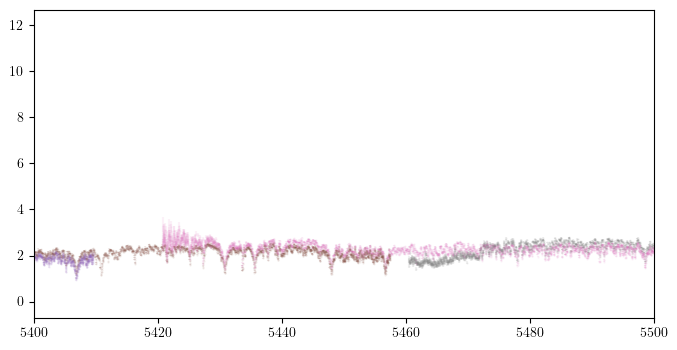

In [10]:
off_set = 0.0
plt.figure(figsize=(8,4))
for ii in range(n_orders):
    plt.errorbar(hdu1[4].data[ii,:],hdu1[1].data[ii,:]+off_set,\
                     yerr=hdu1[3].data[ii,:],fmt='.',zorder=2,alpha=0.1,ms=1)

    off_set += 0.2
plt.xlim(5400,5500)
plt.show()

In [11]:
observatory_name = 'Calar Alto'
lat = 2.5468465
long = 37.220791
elevation = 2168
loc = coord.EarthLocation.from_geodetic(long,lat,elevation)
star_name = 'GJ 2'
resolution  = 100_000
star = coord.SkyCoord.from_name(star_name,parse=True)

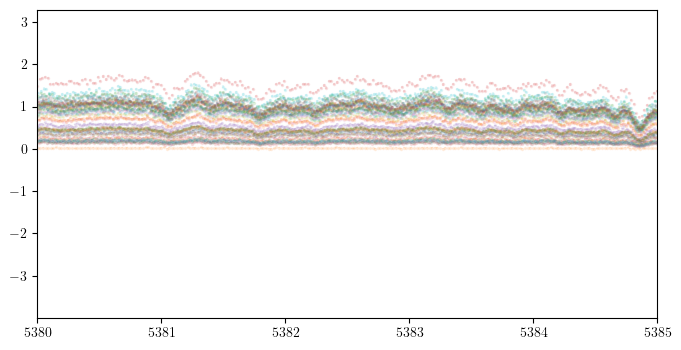

In [12]:
def redshift_correction(wavelength,radial_velocity):
    z = radial_velocity/const.c
    return (1+z)*wavelength

off_set = 0.0
plt_order = 4
plt.figure(figsize=(8,4))
for file in files:
    hdu1 = fits.open(file)
    time = at.Time(hdu1[0].header['DATE-OBS'], \
             format='isot', scale='utc')
    bc = star.radial_velocity_correction(obstime=time, location=loc).to(u.m/u.s).value

    plt.errorbar(redshift_correction(hdu1[4].data[plt_order,:],bc),hdu1[1].data[plt_order,:]+off_set,\
                     yerr=hdu1[3].data[plt_order,:],fmt='.',zorder=2,alpha=0.1,ms=3)

    off_set += 0.0
plt.xlim(5380,5385)
plt.show()

In [13]:
def get_normalization_model(dataset, norm_p_val: int, norm_pts: int):
    len_xs = np.max(
        [np.max(dataframe.xs) - np.min(dataframe.xs) for dataframe in dataset]
    )
    min_xs = np.min([np.min(dataframe.xs) for dataframe in dataset])
    max_xs = np.max([np.max(dataframe.xs) for dataframe in dataset])

    shifts = jnp.array([dataframe.xs.min() - min_xs for dataframe in dataset])
    x_spacing = len_xs / norm_pts
    x_grid = jnp.linspace(-x_spacing*((norm_p_val + 1)//2), len_xs + (x_spacing*((norm_p_val + 1)//2)), norm_pts + norm_p_val + 1) + min_xs
    model = jabble.model.CardinalSplineMixture(x_grid, norm_p_val)
    size = len(dataset)

    p = jnp.tile(model.p, size)
    norm_model = jabble.model.NormalizationModel(p, model, size)
    return jabble.model.ShiftingModel(shifts).composite(norm_model)

def get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_vels,airmass):
         
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")

    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    init_shifts = jabble.physics.shifts(init_rvs)
    rest_shifts = jabble.physics.shifts(rest_vels)
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts,which_key='times'),#ShiftingModel(init_shifts),#
            jabble.model.CardinalSplineMixture(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(rest_shifts,which_key='times'),
            jabble.model.CardinalSplineMixture(model_grid, p_val),
            jabble.model.StretchingModel(jnp.array(airmass)),
        ]
    )

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

In [14]:
def get_dataset(files,echelle_order,epsilon=np.exp(-11)):
    iteration = 0
    airmasses = np.zeros(shape=(0))
    bcs = np.zeros(shape=(0))
    jds = np.zeros(shape=(0))
    filenames = np.zeros(shape=(0))
    objnames = np.zeros(shape=(0))
    fluxes   = []
    waves    = []
    yivar    = []
    mask = []
    for file in files:
        
        try:
            hdu1 = fits.open(file)
        except:
            print(file)
            continue
            
        airmass = float(hdu1[0].header['AIRMASS'])
        
        flux = np.array(hdu1[1].data[echelle_order,:],dtype=np.float64)
        xs = np.log(jnp.array(hdu1[4].data[echelle_order,:],dtype=np.float64))
        ys = np.log(flux)
        yerr = np.array(hdu1[3].data[echelle_order,:],dtype=np.float64)/flux
        ma = np.isnan(yerr) | np.isinf(yerr) | np.isinf(flux) | (flux <= epsilon) | np.isnan(flux)
        # objname = hdu1[0].header['OBJFILE']

        ys[ma] = 0.0
        yerr[ma] = 1e20
        xs[ma] = np.min(xs)

        time = at.Time(hdu1[0].header['DATE-OBS'], \
             format='isot', scale='utc')
            
        fluxes.append(ys)
        waves.append(xs)
        yivar.append(1/yerr**2)
        mask.append(ma)
        
        bc = star.radial_velocity_correction(obstime=time, location=loc).to(u.m/u.s).value

        airmasses = np.concatenate((airmasses,[airmass]))
        bcs = np.concatenate((bcs,[bc]))
        jds = np.concatenate((jds,[time.jd]))
        filenames = np.concatenate((filenames,[file]))
        # objnames = np.concatenate((objnames,[objname]))
        
    dataset = jabble.dataset.Data.from_lists(waves,fluxes,yivar,mask)
    dataset.metadata['times'] = jds
    dataset.metadata['airmasses'] = airmasses

    return dataset, airmasses, bcs, jds

In [15]:
def clip_ends(norm_dataset,dataset):
    for dataframe,norm_dataframe in zip(dataset,norm_dataset):
        new_mask  = np.zeros(norm_dataframe.mask.shape,dtype=bool)
        indices, = np.where(norm_dataframe.mask == 0)
        i = np.min(indices)
        j = np.max(indices)
        
        new_mask[:(i+1)] = True
        new_mask[j:] = True

        dataframe.mask = (dataframe.mask + new_mask).astype(bool)
    return dataset 

def train_norm(model, dataset, loss, device_store, device_op, batch_size,nsigma = [0.5,2], maxiter=3):
    options = {"maxiter": 32,\
               "factr": 1e4,\
              }
        
    # Fit Normalization Template
    for iii in range(maxiter):
        model.fix()
        model.fit(2, 1)
        
        res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
        print(res1)
        model.fix()
        _,metablock = dataset.blockify(device_op)
        for data_epoch in range(len(dataset)):

            mask    = dataset[data_epoch].mask
            metarow = jabble.loss.dict_ele(metablock,data_epoch,device_op)
            resid = dataset[data_epoch].ys - model([],dataset[data_epoch].xs,metarow)
            sigma = np.sqrt(np.nanmedian(resid**2))
            m_new = (resid < -nsigma[0]*sigma) | (resid > nsigma[1]*sigma)
            dataset[data_epoch].mask = mask | m_new[:len(mask)]

    return model

def train_cycle(model, dataset, loss, device_store, device_op, batch_size):
    options = {"maxiter": 10_000,\
               "factr": 10.0,\
              }

    # Fit Stellar & Telluric Template
    model.fix()
    model.fit(0,1)
    model.fit(1,1)
    model.display()
    
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0,0)
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)
    print(res1)

    # RV Parabola Fit
    # model.fix()
    # search_space = np.linspace(-100, 100, 500)
    # shift_search = jabble.physics.shifts(search_space)

    # sgrid = model[0][0].p[:,None] + shift_search[None,:]
    # lgrid = model[0][0].grid_search(sgrid, loss, model, dataset, device_op)
    
    # for i in range(lgrid.shape[0]):
    #     if np.argmin(lgrid[i,:]) == 0 or np.argmin(lgrid[i,:]) == lgrid.shape[1] - 1:
    #         plt.plot(shift_search,lgrid[i,:])
    #         plt.show()
    
    # model[0][0].parabola_fit(shift_search, loss, model, dataset, device_op, device_store)
    # model.to_device(device_op)

    # Fit Everything
    model.fix()
    model.fit(0,0)
    model.fit(0,1)
    model.fit(1,1)
    # model.fit(2,1)

    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)

    return model

In [17]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")

echelle_order = 51
resolution = 85_000
p_val = 3
vel_padding = 100 * u.km / u.s

lmb = 1e-6

norm_p_val = 2
norm_pts   = 4

star_name = 'GJ2'
os.makedirs(os.path.join(out_dir,star_name),exist_ok=True)
print(np.arange(n_orders))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]


In [25]:
device_store = cpus[0]
device_op = cpus[0]
batch_size = 5000

# out_dir = '/scratch/mdd423/wobble_jax/out/25-07-09/'range(hdu1[1].data.shape[0])
for echelle_order in [52]:#range(n_orders):#[32]:

    data_name = os.path.join(out_dir,star_name,'{}_data_o{}_norm.pkl'.format(star_name,echelle_order))
    model_name = os.path.join(out_dir,star_name,'{}_model_o{}_norm.pkl'.format(star_name,echelle_order))
    if not os.path.isfile(model_name) or True:
        
        dataset, airmasses, bcs, jds = get_dataset(files,echelle_order)
        norm_dataset = copy.deepcopy(dataset)
                
        init_rvs = -bcs#ccf_arr_obj['ccf_rvc'] - ccf_arr_obj['ccf_rvs']
        rest_rvs = np.zeros(init_rvs.shape)
        print(init_rvs.shape,rest_rvs.shape)
        dataset.metakeys['times'] = jds
        
        model =  get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_rvs,airmasses)
        norm_model = get_normalization_model(dataset,norm_p_val,norm_pts)
        model += norm_model
        print(np.sum(np.concatenate(dataset.yivar)),np.sum(np.concatenate(dataset.ys)),np.sum(np.concatenate(dataset.xs)))
        reg_s = lmb*jabble.loss.L1Reg([0,1]) * np.nansum(np.concatenate(dataset.yivar))
        reg_t = lmb*jabble.loss.L1Reg([1,1]) * np.nansum(np.concatenate(dataset.yivar))
        model.metadata = dataset.metadata

        loss = jabble.loss.ChiSquare()

        model.display()

        model = train_norm(model, norm_dataset, loss, device_store, device_op, batch_size,maxiter=3,nsigma=[0.5,3])
        dataset = clip_ends(norm_dataset,dataset)
        
        # sorted_epoches = np.argsort([dataframe.yivar.sum()for dataframe in dataset])
        # plt_epoches = [sorted_epoches[0],sorted_epoches[1],sorted_epoches[2],sorted_epoches[3]]

        # fig, axes = plt.subplots(2,len(plt_epoches),figsize=(8,2),sharex='col',sharey='row',\
        #                              facecolor=(1, 1, 1),height_ratios=[3,1],dpi=200)
        
        # plt.subplots_adjust(wspace=0.3)
        # model.to_device(cpus[0])
        # dataset.to_device(cpus[0])
        
        # lrange = np.linspace(7030,7160,2)[:,None]
        # epoch_str = ''
        # # lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
        # for ii,plt_epoch in enumerate(plt_epoches):
        #     # axes[0,ii] = make_subplot_norm(axes[0,ii],model,dataset,None,plt_epoch,cpus[0],lrange[:,0],nsigma=[0.5,3])
            
        #     # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
        #     axes[:,ii] = make_subplot(axes[:,ii],model,dataset,plt_epoch,cpus[0],lrange[:,0])
        
        #     epoch_str += '.' + str(plt_epoch)
        # plt_name = os.path.join(out_dir,"{}_spectra_l{}-{}_e{}_o{}.png".format(star_name,lrange.min(),lrange.max(),epoch_str,echelle_order))
        
        # fig.suptitle('{}_e{}_o{}'.format(star_name,epoch_str,echelle_order),y=0.95)
        # fig.text(0.5, 0.01, 'Wavelength [$\\AA$]', ha='center')
        # # plt.savefig(plt_name)
        # plt.show()
        model = train_cycle(model, dataset, loss + reg_s + reg_t, device_store, device_op, batch_size)

        rv_model = model
        for ii in [0,0]:
            rv_model = rv_model[ii]
        rv_model.display()
        
        jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,device=device_op,loss=loss,rv_ind=[0,0])
        break
    else:
        print('skipping order {}'.format(echelle_order))

/state/partition1/job-1054776/ipykernel_4050176/1904827654.py:24: RuntimeWarning: invalid value encountered in log
  ys = np.log(flux)


(53,) (53,)
2180654298.2708244 -653818.9267093418 1982995.548298631
-AdditiveModel------------------------------------0
  0-CompositeModel-------------------------------------------------0
  0  0-ShiftingModel-----------------------------------------------0
  0  1-CardinalSplineMixture---------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel-----------------------------------------------0
  1  1-CardinalSplineMixture---------------------------------------0
  1  2-StretchingModel---------------------------------------------0
  2-CompositeModel-------------------------------------------------0
  2  0-ShiftingModel-----------------------------------------------0
  2  1-NormalizationModel------------------------------------------0
{'grad': array([ 5.25039735e+04,  2.45969400e+04, -1.91111199e+02, -4.29454483e+04,
        1.92383925e+04, -2.71284018e+03,  6.66002556e+04,  4.34498865e+04,
       -4.06726617e+04, -7.8319

In [32]:
echelle_order = 52
open_dir = os.path.join('/scratch/mdd423/wobble_jax','out','25-10-20')#out_dir
data_name = os.path.join(open_dir,star_name,'{}_data_o{}_norm.pkl'.format(star_name,echelle_order))
model_name = os.path.join(open_dir,star_name,'{}_model_o{}_norm.pkl'.format(star_name,echelle_order))
model = jabble.model.load(model_name)
dataset = jabble.model.load(data_name)

In [33]:
def make_subplot(axes,model,dataset,plt_epoch,device,lrange):

    model.fix()
    data, meta, keys = dataset.blockify(device,return_keys=True)
    
    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,metarow)
    yplot_norm_stel = model[0]([],xplot,metarow)
    yplot_norm_tell = model[1]([],xplot,metarow)
    # yplot_norm      = model[2]([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat_norm = model[2]([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)
    yhat_norm_mask = model[2]([],dataset.xs[plt_epoch][datarow["mask"]],metarow)

    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)

    axes[0].set_xlim(xplot.min(),xplot.max())

    # velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes[0].errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]] - yhat_norm,\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=0.5,alpha=0.3,ms=1)

    axes[0].plot(datarow["xs"][datarow["mask"]],datarow["ys"][datarow["mask"]] - yhat_norm_mask,\
                     '.b',zorder=0.5,alpha=0.3,ms=1)

    # Stellar Model        
    axes[0].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Telluric M
    axes[0].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Total
    # axes[0].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Norm
    # axes[0].plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Theory Model
    # theory_ax = axes[0,ii].twinx()
    # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # theory_ax.set_ylim(-5,5)
    # Line List
 
    # Residuals
    axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
                             'k',where='mid',zorder=1,alpha=0.3,ms=3)

    

    axes[0].set_ylim(-1.2,0.5)
    axes[1].set_ylim(-0.5,0.5)
    
    # axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticks(np.log(lrange))

    axes[0].set_xticklabels(['' for x in lrange])
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

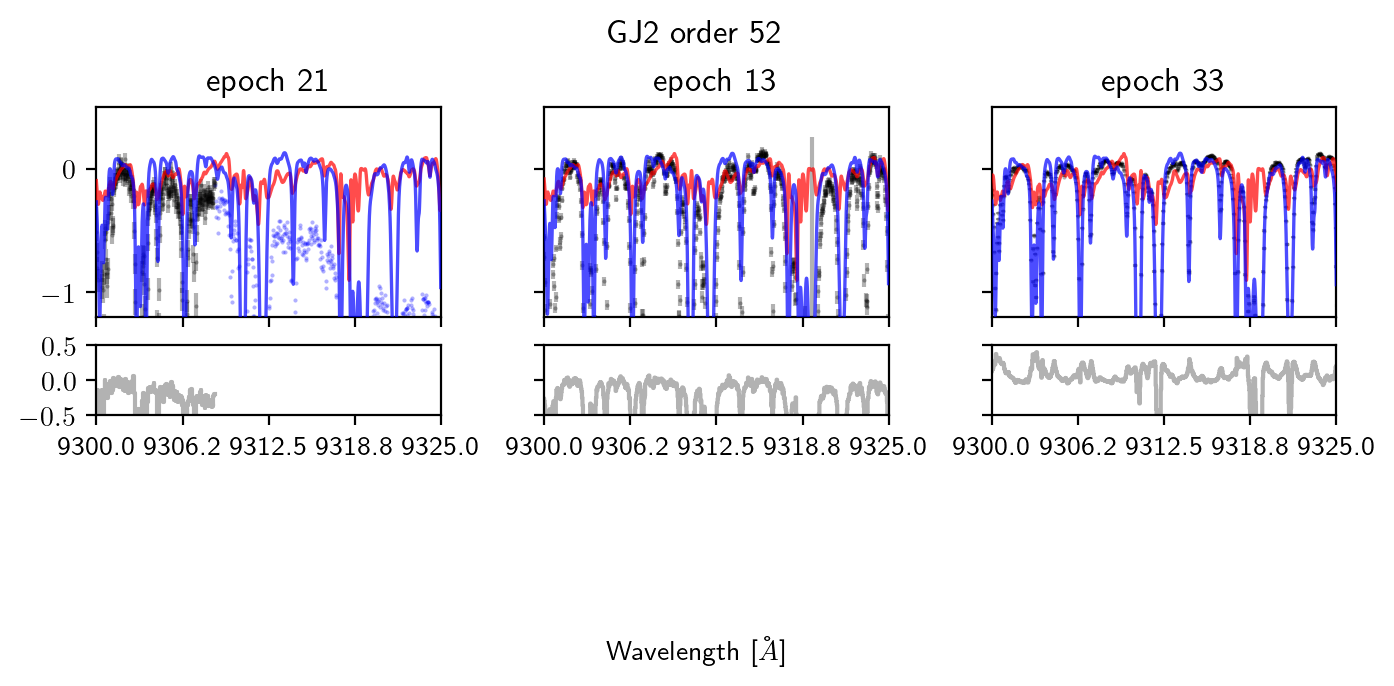

In [43]:
sorted_epoches = np.argsort([dataframe.yivar.sum()for dataframe in dataset])
plt_epoches = [sorted_epoches[0],sorted_epoches[1],sorted_epoches[-1]]

fig, axes = plt.subplots(2,len(plt_epoches),figsize=(8,2),sharex='col',sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[3,1],dpi=200)

plt.subplots_adjust(wspace=0.3)
model.to_device(cpus[0])
dataset.to_device(cpus[0])
# norm_dataset.to_device(cpus[0])

# plt_width = np.arange(-40,40,20) + 10
# plt_epoch = 19

# lrange = np.linspace(int(np.mean(np.exp(dataset[plt_epoch].xs))),\
#                      int(np.mean(np.exp(dataset[plt_epoch].xs)))+10,4)[:,None]
lrange = np.linspace(9300,9325,5)[:,None]
epoch_str = ''
# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
for ii,plt_epoch in enumerate(plt_epoches):
    # axes[0,ii] = make_subplot_norm(axes[0,ii],model,dataset,None,plt_epoch,cpus[0],lrange[:,0],nsigma=[0.5,3])
    
    # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
    axes[:,ii] = make_subplot(axes[:,ii],model,dataset,plt_epoch,cpus[0],lrange[:,0])
    axes[0,ii].set_title('epoch {}'.format(plt_epoch))
    epoch_str += '.' + str(plt_epoch)
plt_name = os.path.join(out_dir,"{}_spectra_l{}-{}_e{}_o{}.png".format(star_name,\
                                                                       lrange.min(),lrange.max(),\
                                                                       epoch_str,echelle_order))

fig.suptitle('{} order {}'.format(star_name,echelle_order),y=1.1)
fig.text(0.5, -0.05, 'Wavelength [$\\AA$]', ha='center')
plt.savefig(plt_name)
plt.show()

In [29]:
def make_subplot_norm(axes,model,dataset,norm_dataset,plt_epoch,device,lrange,nsigma):

    model.fix()
    data, meta, keys = dataset.blockify(device,return_keys=True)
    
    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
    if isinstance(norm_dataset,jabble.dataset.Data):
        ndata,nmeta = norm_dataset.blockify(device)
        ndatarow = jabble.loss.dict_ele(ndata,plt_epoch,device)
        nmetarow = jabble.loss.dict_ele(nmeta,plt_epoch,device)
        axes.errorbar(ndatarow["xs"][~ndatarow["mask"]],ndatarow["ys"][~ndatarow["mask"]],\
                     yerr=1/np.sqrt(ndatarow["yivar"][~ndatarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=2)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,metarow)
    yplot_norm_stel = model[0]([],xplot,metarow)
    yplot_norm_tell = model[1]([],xplot,metarow)
    yplot_norm      = model[2]([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)
    axes.set_xlim(xplot.min(),xplot.max())

    velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes.errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]],\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.3,ms=1)

    
    # Stellar Model        
    # axes.plot(xplot,yplot_norm_stel + yplot_norm,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # # Telluric M
    # axes.plot(xplot,yplot_norm_tell + yplot_norm,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Total
    # axes[0].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Norm
    axes.plot(xplot,yplot_norm,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)

    # axes.plot(xplot,yplot_norm+nsigma[1],'-m',linewidth=1.2,zorder=10,alpha=0.35,ms=6)
    # axes.plot(xplot,yplot_norm-nsigma[0],'-m',linewidth=1.2,zorder=10,alpha=0.35,ms=6)

    # Theory Model
    # theory_ax = axes[0,ii].twinx()
    # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # theory_ax.set_ylim(-5,5)
    # Line List
 
    # Residuals
    # axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
    #                          'k',where='mid',zorder=1,alpha=0.3,ms=3)

    # if "orders" in model.metadata:
        
    #     axes[0].text(np.log(lrange.min()+0.1),0.3,"Order: ${}$".format(model.metadata["orders"][plt_epoch]))
    # axes[0].text(np.log(lrange.max()-0.1),0.3,"MJD: ${}$".format(model.metadata["times"][plt_epoch]))

    # axes[0].set_ylim(-2.5,0.5)
    # axes.set_ylim(-5,0)
    
    # axes[0].set_xticks([])
    axes.set_xticks(np.log(lrange))
    # axes[1].set_xticks(np.log(lrange))

    axes.set_xticklabels(['{}'.format(x) for x in lrange])
    # axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes.set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    # axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

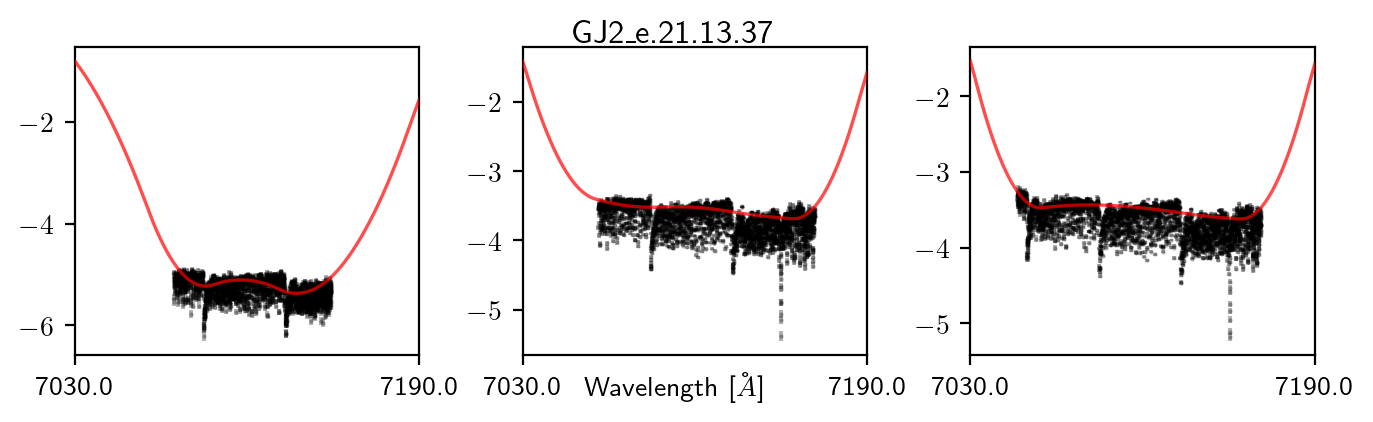

In [30]:
plt_epoches = [sorted_epoches[0],sorted_epoches[1],sorted_epoches[2]]

fig, axes = plt.subplots(1,len(plt_epoches),figsize=(8,2),sharex='col',sharey=False,\
                             facecolor=(1, 1, 1),dpi=200)

plt.subplots_adjust(wspace=0.3)
model.to_device(cpus[0])
dataset.to_device(cpus[0])
# norm_dataset.to_device(cpus[0])

# lrange = np.linspace(int(np.mean(np.exp(dataset[plt_epoch].xs))),\
#                      int(np.mean(np.exp(dataset[plt_epoch].xs)))+10,4)[:,None]
lrange = np.linspace(7030,7190,2)[:,None]
epoch_str = ''
# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
for ii,plt_epoch in enumerate(plt_epoches):
    axes[ii] = make_subplot_norm(axes[ii],model,dataset,None,plt_epoch,cpus[0],lrange[:,0],nsigma=[0.5,2])
    
    # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
    # axes[:,ii] = make_subplot(axes[:,ii],model,dataset,plt_epoch,cpus[0],lrange[:,0])

    epoch_str += '.' + str(plt_epoch)
plt_name = os.path.join(out_dir,"{}_spectra_norm_l{}-{}_e{}.png".format(star_name,lrange.min(),lrange.max(),epoch_str))

fig.suptitle('{}_e{}'.format(star_name,epoch_str),y=0.95)
fig.text(0.5, 0.01, 'Wavelength [$\\AA$]', ha='center')
plt.savefig(plt_name)
plt.show()

In [24]:
sorted_epoches = np.argsort([dataframe.yivar.sum()for dataframe in dataset])

In [25]:
print(len(sorted_epoches))

53


In [56]:
def plt_rv_comparison(times, rv_e, err_e, targ_time, targ_vel, targ_err, ccf_vel,ccf_err,bervs):
    
    epoches_span = np.arange(0, len(times), dtype=int)

    # RV Comparison

    fig, ax = plt.subplots(
        1,
        figsize=(8, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )
    
    targ_ind = np.argsort(targ_time)
    comb_indi = np.argsort(np.argsort(times))#[targ_ind][comb_indi]

    bervs_temp = -bervs + bervs.mean()
    norm_vel   = bervs_temp #(targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean())

    targ_norm  = (targ_vel - targ_vel.mean())
    targ_line = ax.errorbar(targ_time - 2457000,targ_norm,targ_err,fmt='.g',zorder=3,alpha=0.5,ms=2,\
                            label='SERVAL RV')

    # ccf_norm  = (ccf_vel - ccf_vel.mean())
    # ccf_line = ax.errorbar(targ_time,ccf_norm,ccf_err,fmt='.b',zorder=3,alpha=0.5,ms=2,\
    #                        label='CCF RV')
    
    
    rv_norm = (rv_e - rv_e.mean()) - norm_vel[targ_ind][comb_indi]
    rv_line = ax.errorbar(times - 2457000,rv_norm,err_e,fmt='.r',zorder=2,alpha=0.3,ms=2,label='Jabble RV')

    
    ax.legend(handles=[targ_line,rv_line],loc="lower right")

    # ax.set_title('Barnard\'s Star Relative Radial Velocities')
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "MJD - 2,457,000")
    # ax.set_xlim(2.456e6 + 451,2.456e6+452)
    # ax.set_ylim(-50,50)
    plt.savefig(os.path.join(out_dir, "{}_o{}_rvs.png".format(star_name,echelle_order)),bbox_inches='tight')
    plt.show()    

In [57]:
rv_array =  h5py.File('/scratch/mdd423/wobble_jax/out/25-10-08/GJ2/GJ2_model_o32_norm.pkl_RVS.hdf',\
                      'r')
df = pd.read_csv('/scratch/mdd423/wobble_jax/data/J00051+457_VIS/J00051+457_SERVAL+RACOON.csv')

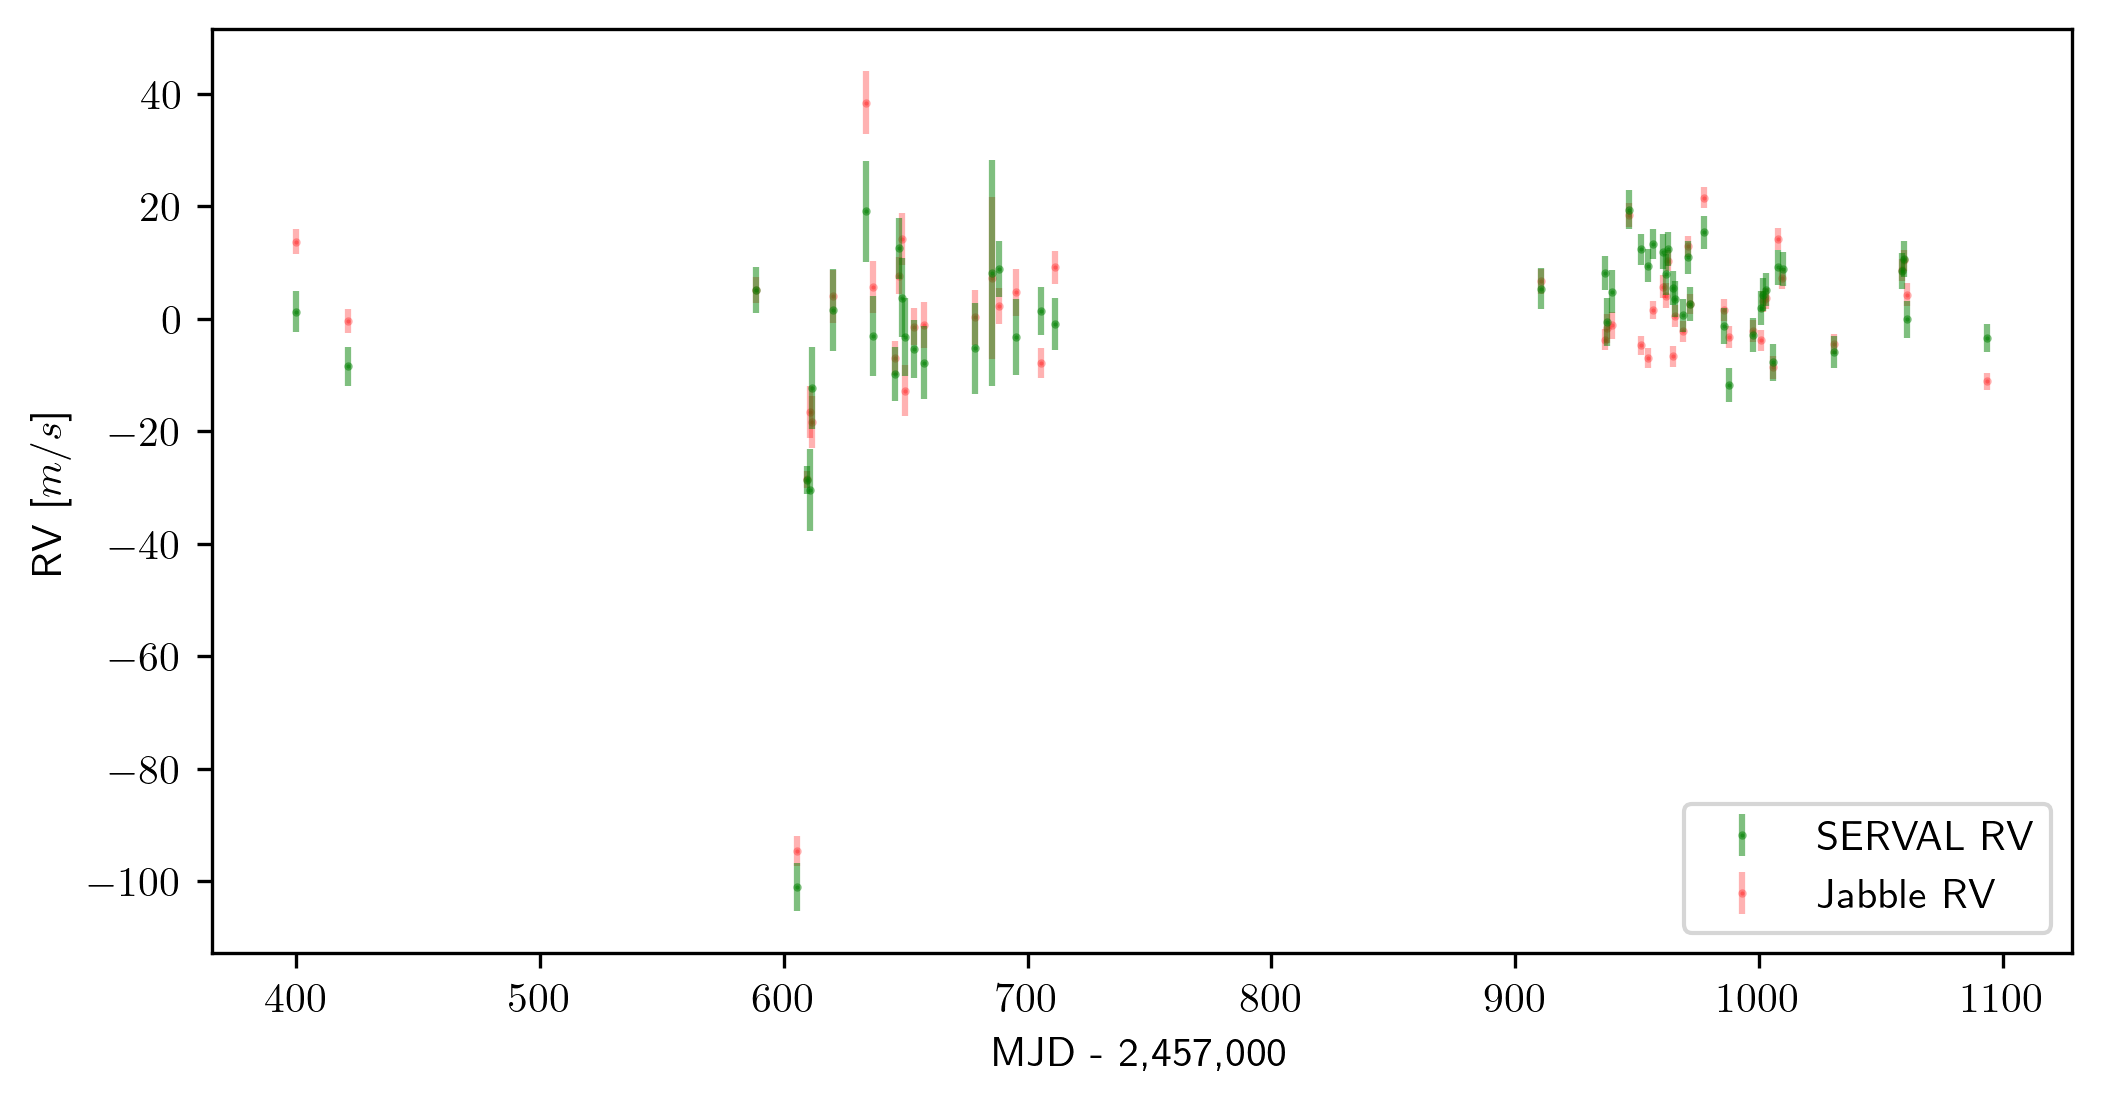

In [58]:
plt_rv_comparison(rv_array['Times'][:], rv_array['RVs'][:], rv_array['RV_err'][:],\
                  df['BJD'], df['RVO_090'] , df['E_RVO_090'],df['CCF.RVO_090'] , \
                  df['CCF.E_RVO_090'],1000*df['BERV'])

In [25]:
rv_array.keys()

<KeysViewHDF5 ['Loss', 'RV_err', 'RVs', 'Times']>

In [126]:
all_keys = df.keys()

In [128]:
for key in all_keys:
    print(key)

BJD
RVC
E_RVC
AVC
E_AVC
CRX
E_CRX
DLW
E_DLW
CCF_RV
CCF_E_RV
CCF_FWHM
CCF_E_FWHM
CCF_CONTRAST
CCF_E_CONTRAST
CCF_BIS
CCF_E_BIS
HALPHA
E_HALPHA
HACEN
E_HACEN
HALEFT
E_HALEFT
HARIGH
E_HARIGH
CAI
E_CAI
CAIRT1
E_CAIRT1
CAIRT2
E_CAIRT2
CAIRT3
E_CAIRT3
NAD1
E_NAD1
NAD2
E_NAD2
SNREF
EXPTIME
FLAG
AIRMASS
DRIFT
E_DRIFT
BERV
SADRIFT
TIMEID
RV
E_RV
RVMED
E_RVMED
RVO_118
E_RVO_118
RVO_117
E_RVO_117
RVO_116
E_RVO_116
RVO_115
E_RVO_115
RVO_114
E_RVO_114
RVO_113
E_RVO_113
RVO_112
E_RVO_112
RVO_111
E_RVO_111
RVO_110
E_RVO_110
RVO_109
E_RVO_109
RVO_108
E_RVO_108
RVO_107
E_RVO_107
RVO_106
E_RVO_106
RVO_105
E_RVO_105
RVO_104
E_RVO_104
RVO_103
E_RVO_103
RVO_102
E_RVO_102
RVO_101
E_RVO_101
RVO_100
E_RVO_100
RVO_099
E_RVO_099
RVO_098
E_RVO_098
RVO_097
E_RVO_097
RVO_096
E_RVO_096
RVO_095
E_RVO_095
RVO_094
E_RVO_094
RVO_093
E_RVO_093
RVO_092
E_RVO_092
RVO_091
E_RVO_091
RVO_090
E_RVO_090
RVO_089
E_RVO_089
RVO_088
E_RVO_088
RVO_087
E_RVO_087
RVO_086
E_RVO_086
RVO_085
E_RVO_085
RVO_084
E_RVO_084
RVO_083
E_RVO_083

In [150]:
df['DLW_090']

0      -6.927048
1       4.574262
2      40.658565
3       0.480618
4       1.463006
5     -20.860903
6     -53.593851
7     -49.298690
8     -27.388020
9      -6.927861
10    -14.519804
11     -5.945145
12    -21.214582
13    -41.687788
14     -8.282304
15    -28.878605
16     28.461020
17   -154.854064
18    -26.964733
19    -13.958409
20      4.264636
21    -14.830287
22     -5.613165
23      3.954530
24     -7.600022
25     -0.056702
26      3.289049
27      6.611307
28     -5.597339
29      1.740977
30      3.310978
31     -3.383095
32      2.098946
33      2.490055
34      7.588977
35      2.560113
36      7.885697
37      9.168408
38      3.373409
39      2.999143
40     -6.629726
41      2.292076
42      4.009041
43      2.132261
44      5.829116
45     -3.552715
46      1.744684
47      7.101747
48     -0.854876
49      7.517817
50     11.810722
51     12.238984
52     -4.324605
Name: DLW_090, dtype: float64

In [135]:
hdu1[1].header

XTENSION= 'IMAGE   '           /Image Extension created by MWRFITS v1.12        
BITPIX  =                  -32 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 4096 /                                                
NAXIS2  =                   61 /                                                
EXTNAME = 'SPEC    '           /                                                
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 /                                                

In [137]:
58 + 32

90